AB_Testing_Step_by_Step_and_Hypothesis_testing
------

### 문서 목적
Kaggle notebook 내용을 바탕으로 AB Testing 을 학습하고 이해한다.

### 자료 출처
- 참고 문서 : https://www.kaggle.com/ekrembayar/a-b-testing-step-by-step-hypothesis-testing
- 데이터셋 : 링크 참고

분석 개요

> Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

> As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

> To complete this project, you should be comfortable working with pandas DataFrames and with using the pandas plot method. You should also have some understanding of hypothesis testing and bootstrap analysis.

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first week after installation
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

**AB Testing Process**
1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
  - Check Normality & Homogeneity
  - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
5. Evaluate the results
6. Make inferences
7. Recommend business decision to your customer/director/ceo etc.

------

### 1. Packages

In [1]:
# Base

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing

from scipy.stats import shapiro
import scipy.stats as stats

# Configuration

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

### 2. DATA

In [2]:
ab = pd.read_csv("cookie_cats.csv")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
ab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### 3. SUMMARY STATS

In [4]:
ab.userid.nunique()

90189

In [5]:
ab.userid.nunique() == ab.shape[0]

True

In [6]:
ab.describe(
    [0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99]
)[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,49854.0000


In [7]:
# A/B Groups & Target Summary Stats

ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17,52.4563,256.7164,49854
gate_40,45489,16,51.2988,103.2944,2640


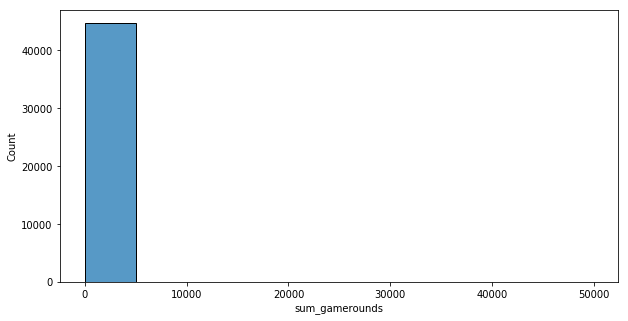

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(x="sum_gamerounds", data=ab[ab['version']=='gate_30'], bins=10)
plt.show()

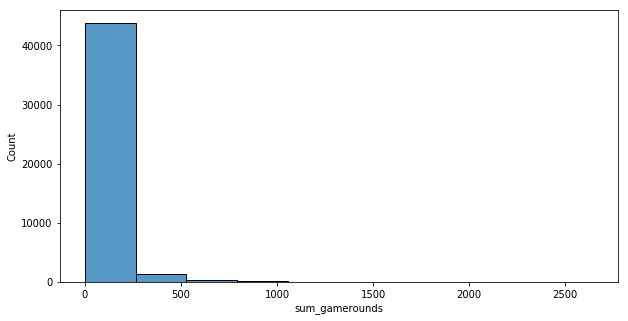

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(x="sum_gamerounds", data=ab[ab['version']=='gate_40'], bins=10)
plt.show()

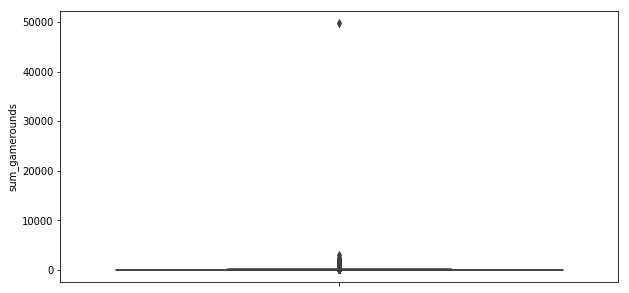

In [10]:
plt.figure(figsize=(10, 5))
sns.boxplot(y="sum_gamerounds", data=ab[ab['version']=='gate_30'])
plt.show()

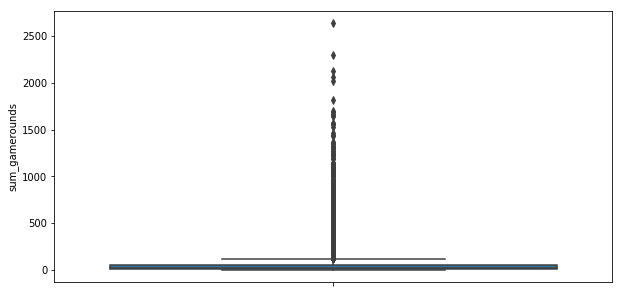

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(y="sum_gamerounds", data=ab[ab['version']=='gate_40'])
plt.show()

In [12]:
# sns.barplot(x='userid', y='sum_gamerounds', data=ab)

### 4. OUTLIERS

In [13]:
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.01, 0.05, 0.10, 0.20, 0.80, 0.90, 0.95, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,1%,5%,10%,20%,50%,80%,90%,95%,99%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,0.0000,1.0000,1.0000,3.0000,16.0000,67.0000,134.0000,221.0000,493.0000,2961.0000


### 5. SOME DETAILS

In [14]:
ab.groupby(by="sum_gamerounds").count()[['userid']].head()

,userid
sum_gamerounds,
0,3994
1,5538
2,4606
3,3958
4,3629


The users installed the game but 3994 users never played the game! Some reasons might explain this situation.
- They have no free time to play game
- Users might prefer to play other games or they play other games already
- Some users don't like the app etc.
- You can comment below for this users also

The number of users decreases as the levels progress
- Most of users played the game at early stage and they didn't progress.
- Tactile Entertainment should learn why users churn playing the game.
- Doing research and collecting data about the game and users would help to understand user churn
- The difficulty of the game can be measured
- Gifts might help player retention

In [15]:
ab_groupby_df = ab.groupby(by="sum_gamerounds", as_index=False).count()[['userid']]

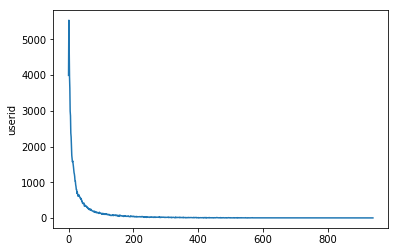

In [16]:
sns.lineplot(x=ab_groupby_df.index, y='userid', data=ab_groupby_df)
plt.show()

In [17]:
# How many users reached gate 30 & gate 40 levels?

ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

In [18]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17,51.3421,102.0576,2961
gate_40,45489,16,51.2988,103.2944,2640


Retention variables gives us player retention details.
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

Also players tend not to play the game! There are many players who quit the game.
- 55 percent of the players didn't play the game 1 day after insalling
- 81 percent of the players didn't play the game 7 day after insalling

In [53]:
# !pip install pandas --upgrade

In [20]:
ab['retention_1'].value_counts()

False    50035
True     40153
Name: retention_1, dtype: int64

In [21]:
ab['retention_7'].value_counts()

False    73408
True     16780
Name: retention_7, dtype: int64

In [22]:
ab['retention_1'].value_counts() / len(ab)

False   0.5548
True    0.4452
Name: retention_1, dtype: float64

In [23]:
ab['retention_7'].value_counts() / len(ab)

False   0.8139
True    0.1861
Name: retention_7, dtype: float64

In [24]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665       6 16.3591  36.5284  1072
        True         20034      48 94.4117 135.0377  2961
gate_40 False        25370       6 16.3404  35.9258  1241
        True         20119      49 95.3812 137.8873  2640

In [25]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median     mean      std   max
version retention_7                                       
gate_30 False        36198      11  25.7965  43.3162   981
        True          8501     105 160.1175 179.3586  2961
gate_40 False        37210      11  25.8564  44.4061  2640
        True          8279     111 165.6498 183.7925  2294

Similar results are seen when the number of users who came and did not come 1 day and 7 days after the game was installing. Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 14% of the total users include people who will continue the game in the future.

In [26]:
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)

In [27]:
ab.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7,Retention
0,116,gate_30,3,False,False,0
1,337,gate_30,38,True,False,0
2,377,gate_40,165,True,False,0
3,483,gate_40,1,False,False,0
4,488,gate_40,179,True,True,1
5,540,gate_40,187,True,True,1
6,1066,gate_30,0,False,False,0
7,1444,gate_40,2,False,False,0
8,1574,gate_40,108,True,True,1
9,1587,gate_40,153,True,False,0


In [28]:
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median     mean      std   max
version Retention                                       
gate_30 0          38023      12  28.0703  48.0175  1072
        1           6676     127 183.8863 189.6264  2961
gate_40 0          38983      12  28.1034  48.9278  2640
        1           6506     133 190.2824 194.2201  2294

In [29]:
ab["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), ab.retention_1, ab.retention_7))
ab.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6,11.8197,21.6426,981
1,gate_30,False-True,1825,43,73.1693,93.2223,1072
2,gate_30,True-False,13358,33,49.6945,58.1254,918
3,gate_30,True-True,6676,127,183.8863,189.6264,2961
4,gate_40,False-False,23597,6,11.9133,20.9010,547
5,gate_40,False-True,1773,47,75.2611,94.4780,1241
6,gate_40,True-False,13613,32,50.0255,60.9246,2640
7,gate_40,True-True,6506,133,190.2824,194.2201,2294


### 6. A/B Testing

#### Assumptions:
- Check normality
- If Normal Distribution, check homogeneity

#### Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [30]:
ab['version'] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [31]:
# A/B Testing Function

def ab_test(df, group, target):
    
    # Packages
    
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    
    group_A = df[df[group]=="A"][target]
    group_B = df[df[group]=="B"][target]
    
    # Assumption - Normality
    
    nt_A = shapiro(group_A)[1] < 0.05
    nt_B = shapiro(group_B)[1] < 0.05
    
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (nt_A == False) and (nt_B == False):
        # Parametric Test
        # Assumption: Homogeneity of variances
        levene_test = stats.levene(group_A, group_B)[1] < 0.05
        
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if levene_test == False:
            t_test = stats.ttest_ind(group_A, group_B, equal_var=True)[1]
        
        else:
            t_test = stats.ttest_ind(group_A, group_B, equal_var=False)[1]
            
    else:
        t_test = stats.mannwhitneyu(group_A, group_B)[1]
    
    
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[t_test < 0.05], 
        "p-value":[t_test]
    })
    
    temp["Test Type"] = np.where((nt_A == False) & (nt_B == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    
    # Columns
    if (nt_A == False) & (nt_B == False):
        temp["Homogeneity"] = np.where(levene_test == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp

In [33]:
# Apply A/B Testing
ab_test(ab, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0254,A/B groups are not similar!


### 7. Conclusion

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

Firstly, we investigated relationships and structures in the data. There was no missing value problem but was one outlier problem in the data. Summary stats and plots help us to understand the data and problem.

Before A/B Testing, we shared some details about game, players, problems and suggestion to our customer/director/ceo etc.

After applying A/B Testing, the analysis result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing rejected H0 hypothesis and we learned A/B groups are not similar!

Briefly, There are statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds.


Which level has more advantages in terms of player retention?
- 1-day and 7-day average retention are higher when the gate is at level 30 than when it is at level 40.

In [34]:
ab.groupby("version").retention_1.mean(), ab.groupby("version").retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64, version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)

The gate should be at level 30 but average retentions look like similar. We need more data for similarity.